## Webpage word counter
### With example of world country pages on Wikipedia
An application that extracts the content of a website and displays the most frequently occurring words on that webpage.

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import urllib.request, urllib.error
import operator
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# install geopandas in order to get the shape of countries
!pip install geopandas
import geopandas

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# set word limit
# ie how many times a word has to occur for it to be displayed
# for countries on wikipedia it is set to 20
word_limit = 20

In [3]:
# a helper function to vectorize the tokens
# ie count the occurance of each token in the text
# takes a list of tokens as input
# returns a dictionary containing features as keys and weights as values
def vectorize(tokens):
    # an empty dictionary to be returned at the end
    features = {}
    # iterate through all tokens
    for token in tokens:
        # check if that token already exists in the dictionary
        try:
            i = features[token]
            # if it does, increment the count
            features[token] = i + 1
        # otherwise, assign a count of 1
        except KeyError:
            features[token] = 1
    return features

In [4]:
# a helper function to check that the URL is reachable
# implementation from:
# https://stackoverflow.com/questions/1726402/in-python-how-do-i-use-urllib-to-see-if-a-website-is-404-or-200
def check_URL(url):
    try:
        conn = urllib.request.urlopen(url)
    except urllib.error.HTTPError as e:
        # Return code error (e.g. 404, 501, ...)
        # ...
        print('HTTPError: {}'.format(e.code))
    except urllib.error.URLError as e:
        # Not an HTTP-specific error (e.g. connection refused)
        # ...
        print('URLError: {}'.format(e.reason))
    else:
        # 200
        # ...
        return True

In [5]:
# a function that counts the occurance of words on a webpage
# takes a url as input
# returns a dictionary of words and their occurance frequency 
def top_words(url):
    
    #check the URL
    response = check_URL(url)
    # if rerponse is True, continue
    if response:
        
        # specify the url of the web page
        source = urlopen(url).read()
  
        # make a soup 
        soup = BeautifulSoup(source,'lxml')
        # extract the plain text content from paragraphs
        text = ''
        for paragraph in soup.find_all('p'):
            text += paragraph.text

        # tokenize the words
        tokens = word_tokenize(text, language="english")
        # remove stopwords
        tokens = [word for word in tokens if word.lower() not in stop_words]
        # remove punctuation
        tokens = [word for word in tokens if word.isalpha()]
        # vectorize tokens - count occurance of each word
        vectors = vectorize(tokens)
        # only keep the ones with counts over 20
        vectors_reduced = {key:value for (key,value) in vectors.items() if value >= word_limit}
        # sort the result in descending order
        vectors_sorted =dict(sorted(vectors_reduced.items(), key=operator.itemgetter(1),reverse=True))

        return vectors_sorted

### Example - country pages on wikipedia

#### Option 1
User specifies the country (or other wikipedia page name)

In [6]:
# ask the user for input
user_input = input('Please input country: ')
# convert spaces to underscores
user_input_cleaned = user_input.replace(' ', '_')
# set up a full path for URL
url = 'https://en.wikipedia.org/wiki/' + user_input_cleaned
# run the function to extract the top words
top_words(url)

Please input country: France


{'Europe': 61,
 'European': 48,
 'France': 348,
 'French': 288,
 'Louis': 27,
 'National': 25,
 'Paris': 51,
 'Republic': 27,
 'States': 22,
 'Union': 21,
 'United': 31,
 'War': 20,
 'World': 28,
 'also': 49,
 'among': 22,
 'became': 24,
 'century': 59,
 'climate': 29,
 'countries': 32,
 'country': 50,
 'cultural': 21,
 'de': 81,
 'economic': 22,
 'first': 39,
 'government': 30,
 'important': 21,
 'known': 31,
 'language': 30,
 'largest': 42,
 'law': 34,
 'leading': 21,
 'major': 26,
 'many': 29,
 'military': 20,
 'million': 55,
 'national': 35,
 'one': 55,
 'overseas': 24,
 'part': 20,
 'people': 24,
 'population': 29,
 'power': 22,
 'public': 26,
 'regions': 23,
 'second': 22,
 'several': 21,
 'since': 28,
 'time': 23,
 'well': 27,
 'world': 85}

#### Option 2
Hardcode the full URL - copy and paste from a website

In [7]:
# set up a full path for URL
url = 'https://en.wikipedia.org/wiki/United_Kingdom'
# run the function to extract top words
top_words(url)

{'Britain': 79,
 'British': 112,
 'England': 91,
 'English': 26,
 'Europe': 25,
 'Great': 39,
 'Ireland': 100,
 'Irish': 20,
 'Kingdom': 108,
 'London': 32,
 'Northern': 63,
 'Parliament': 21,
 'Scotland': 68,
 'Scottish': 26,
 'UK': 173,
 'Union': 24,
 'United': 116,
 'Wales': 69,
 'Welsh': 27,
 'also': 25,
 'around': 25,
 'cent': 114,
 'century': 34,
 'countries': 25,
 'country': 24,
 'first': 38,
 'government': 25,
 'include': 25,
 'including': 22,
 'international': 20,
 'largest': 25,
 'million': 34,
 'national': 20,
 'number': 22,
 'people': 28,
 'per': 128,
 'population': 49,
 'since': 20,
 'total': 20,
 'world': 63}

### Top unique word for each country
In this section, I will:
- iterate through a list of countries
- extract top 20 words for each country
- generate a global dictionary of all words and all counts
- genrate a global dictionary for all countries with their words and counts
- for each country, select a word that occurs the most in the wikipedia page. I will exclude words that relate to that country's name or capital as well as some popularily occuring words across all country pages

In [71]:
# first, get a list of countries to search for
# list from: https://github.com/lorey/list-of-countries/blob/master/csv/countries.csv
countries = pd.read_csv('https://raw.githubusercontent.com/lorey/list-of-countries/8663edd9b3a8375601561d0ff77da3ea46c46221/csv/countries.csv', sep=';')
# only keep the relevant columns
countries = countries[['name', 'capital', 'alpha_3']]
# check how many countries there are
no_of_countries = len(countries)
no_of_countries

252

In [92]:
# generate empty global dictionaries for countries and all words
country_dict = {}
word_dict = {}

In [93]:
# iterate through all countries
for index, row in countries.iterrows():
  # convert spaces to underscores and dots to nothing
  country_input_cleaned = row['name'].replace(' ', '_')
  country_input_cleaned = country_input_cleaned.replace('.', '')
  print(row['name'])
  # set up a full path for URL
  url = 'https://en.wikipedia.org/wiki/' + country_input_cleaned
  # run the function to extract the top words
  words = top_words(url)
  # append the words to both dictionaries
  country_dict[(row['name'],row['capital'],row['alpha_3'])] = words
  word_dict = {k: word_dict.get(k, 0) + words.get(k, 0) for k in set(word_dict) | set(words)}

Andorra
United Arab Emirates
Afghanistan
Antigua and Barbuda
Anguilla
Albania
Armenia
Angola
Antarctica
Argentina
American Samoa
Austria
Australia
Aruba
Aland Islands
Azerbaijan
Bosnia and Herzegovina
Barbados
Bangladesh
Belgium
Burkina Faso
Bulgaria
Bahrain
Burundi
Benin
Saint Barthelemy
Bermuda
Brunei
Bolivia
Bonaire, Saint Eustatius and Saba 
Brazil
Bahamas
Bhutan
Bouvet Island
Botswana
Belarus
Belize
Canada
Cocos Islands
Democratic Republic of the Congo
Central African Republic
Republic of the Congo
Switzerland
Ivory Coast
Cook Islands
Chile
Cameroon
China
Colombia
Costa Rica
Cuba
Cape Verde
Curacao
Christmas Island
Cyprus
Czechia
Germany
Djibouti
Denmark
Dominica
Dominican Republic
Algeria
Ecuador
Estonia
Egypt
Western Sahara
Eritrea
Spain
Ethiopia
Finland
Fiji
Falkland Islands
Micronesia
Faroe Islands
France
Gabon
United Kingdom
Grenada
Georgia
French Guiana
Guernsey
Ghana
Gibraltar
Greenland
Gambia
Guinea
Guadeloupe
Equatorial Guinea
Greece
South Georgia and the South Sandwich I

Next, I will explore the top words for all countries.<br>
Rather than counts, I want to look at proportions, so I will divide the counts by the number of counties explored. This would tell me how popular words are in general in proportion to all countries.

In [95]:
# generate a new empty dictionary
word_dict_prop = {}

# iterate through all words
for word, count in word_dict.items():
  word_dict_prop[word] = count / no_of_countries

# see the top results
top_words_sorted = dict(sorted(word_dict_prop.items(), key=operator.itemgetter(1),reverse=True))
top_words_sorted

{'country': 29.186507936507937,
 'government': 17.015873015873016,
 'also': 16.944444444444443,
 'population': 12.305555555555555,
 'first': 10.11111111111111,
 'island': 10.023809523809524,
 'world': 8.817460317460318,
 'French': 7.488095238095238,
 'one': 7.349206349206349,
 'century': 6.916666666666667,
 'United': 6.734126984126984,
 'British': 5.849206349206349,
 'islands': 5.714285714285714,
 'South': 5.650793650793651,
 'European': 4.857142857142857,
 'Islands': 4.837301587301587,
 'years': 4.535714285714286,
 'Africa': 4.353174603174603,
 'Spanish': 4.119047619047619,
 'million': 4.023809523809524,
 'people': 3.9444444444444446,
 'de': 3.9365079365079363,
 'largest': 3.7301587301587302,
 'New': 3.630952380952381,
 'African': 3.4166666666666665,
 'Republic': 3.234126984126984,
 'France': 3.0595238095238093,
 'Europe': 3.0555555555555554,
 'national': 2.996031746031746,
 'States': 2.9047619047619047,
 'many': 2.8968253968253967,
 'state': 2.888888888888889,
 'military': 2.87301587

From visual inspection, I want to keep any words that have the occurance proportion higher that 8. This will remove words like 'population', 'country', 'government' etc.

In [173]:
# for each country in country dictionary, only keep the words whose proportions
# are significant
# also remove words related to country name or capital

# create a new dictionart of countries
country_dict_reduced = {}

#iterate through the dictionary of countries
for name_capital_code, words in country_dict.items():
  # for each country, iterate through the list of words
  # and only keep the ones who have high count compared to global dictionary
  # and are not similar as the name of the country or the capital of the country
  new_words = {}
  # check if capital is NaN
  for word, count in words.items():
    if name_capital_code[1] != name_capital_code[1]:
      capital = ''
    else:
      capital = name_capital_code[1]
    if (int(top_words_sorted[word]) < 8) & (word[:len(word)//2] not in name_capital_code[0]) & \
        (word[:len(word)//2] not in capital):
      new_words[word] = count
  
  # append the country to the new dictionary
  country_dict_reduced[name_capital_code] = new_words

In [174]:
# create a new dictionary
country_top_word = {}

# get the top word from each country
# for each country, only keep the top word if there is one
for country, counts in country_dict_reduced.items():
  # if the words are not empty
  if len(counts) != 0:
    max_word = max(counts, key=counts.get)
    country_top_word[country] = max_word

In [175]:
len(country_top_word)

241

## Create a map with the words marked
Code adated from: https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b

In [176]:
# convert my dictionart of countries to a dataframe
country_words = pd.DataFrame(country_top_word.items(), columns=['CountryCapital', 'word'])
# turn tuples into columns
country_words[['country', 'capital', 'alpha_3']] = pd.DataFrame(country_words['CountryCapital'].tolist(), index=country_words.index)
# only keep relevant columns
country_words = country_words[['country', 'capital', 'alpha_3', 'word']]
country_words.head()

,country,capital,alpha_3,word
0,Andorra,Andorra la Vella,AND,Catalan
1,United Arab Emirates,Abu Dhabi,ARE,Dubai
2,Afghanistan,Kabul,AFG,Taliban
3,Antigua and Barbuda,St. John's,ATG,islands
4,Albania,Tirana,ALB,people


In [177]:
# get a world dataset from geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [178]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [179]:
# merge based on iso code
merge=pd.merge(world,country_words,left_on='iso_a3', right_on='alpha_3')
merge = merge[['country', 'capital', 'alpha_3', 'geometry', 'word']]
merge

,country,capital,alpha_3,geometry,word
0,Fiji,Suva,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",British
1,Tanzania,Dodoma,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",per
2,Western Sahara,El-Aaiun,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",Morocco
3,Canada,Ottawa,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",percent
4,United States,Washington,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",American
...,...,...,...,...,...
163,Bosnia and Herzegovina,Sarajevo,BIH,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",Yugoslavia
164,Serbia,Belgrade,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",European
165,Montenegro,Podgorica,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",became
166,Trinidad and Tobago,Port of Spain,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Caribbean


I have lost some countries at this stage, but that's ok, it should be mostly the small ones which wouldn't be visible on a map anyway. From 230 countries, I went down to 162. This is mostly due to the dataset from geopandas being more limited.

In [181]:
# extract coordinates from the polygons for plotting the words
merge['coords'] = merge['geometry'].apply(lambda x: x.representative_point().coords[:])
merge['coords'] = [coords[0] for coords in merge['coords']]
merge

,country,capital,alpha_3,geometry,word,coords
0,Fiji,Suva,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",British,"(177.9759493013698, -17.937620000000003)"
1,Tanzania,Dodoma,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",per,"(34.14207062768624, -6.207829437269719)"
2,Western Sahara,El-Aaiun,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",Morocco,"(-12.572015437039491, 24.23056264901875)"
3,Canada,Ottawa,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",percent,"(-110.24380777716146, 56.70192)"
4,United States,Washington,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",American,"(-99.31483211377505, 37.23674500000004)"
...,...,...,...,...,...,...
163,Bosnia and Herzegovina,Sarajevo,BIH,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",Yugoslavia,"(18.115159909331382, 43.853096239912816)"
164,Serbia,Belgrade,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",European,"(21.01347524303938, 44.13669650033062)"
165,Montenegro,Podgorica,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",became,"(19.39621631008616, 42.75049869108284)"
166,Trinidad and Tobago,Port of Spain,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Caribbean,"(-61.290352348993295, 10.562500000000002)"


<Figure size 7200x4800 with 0 Axes>

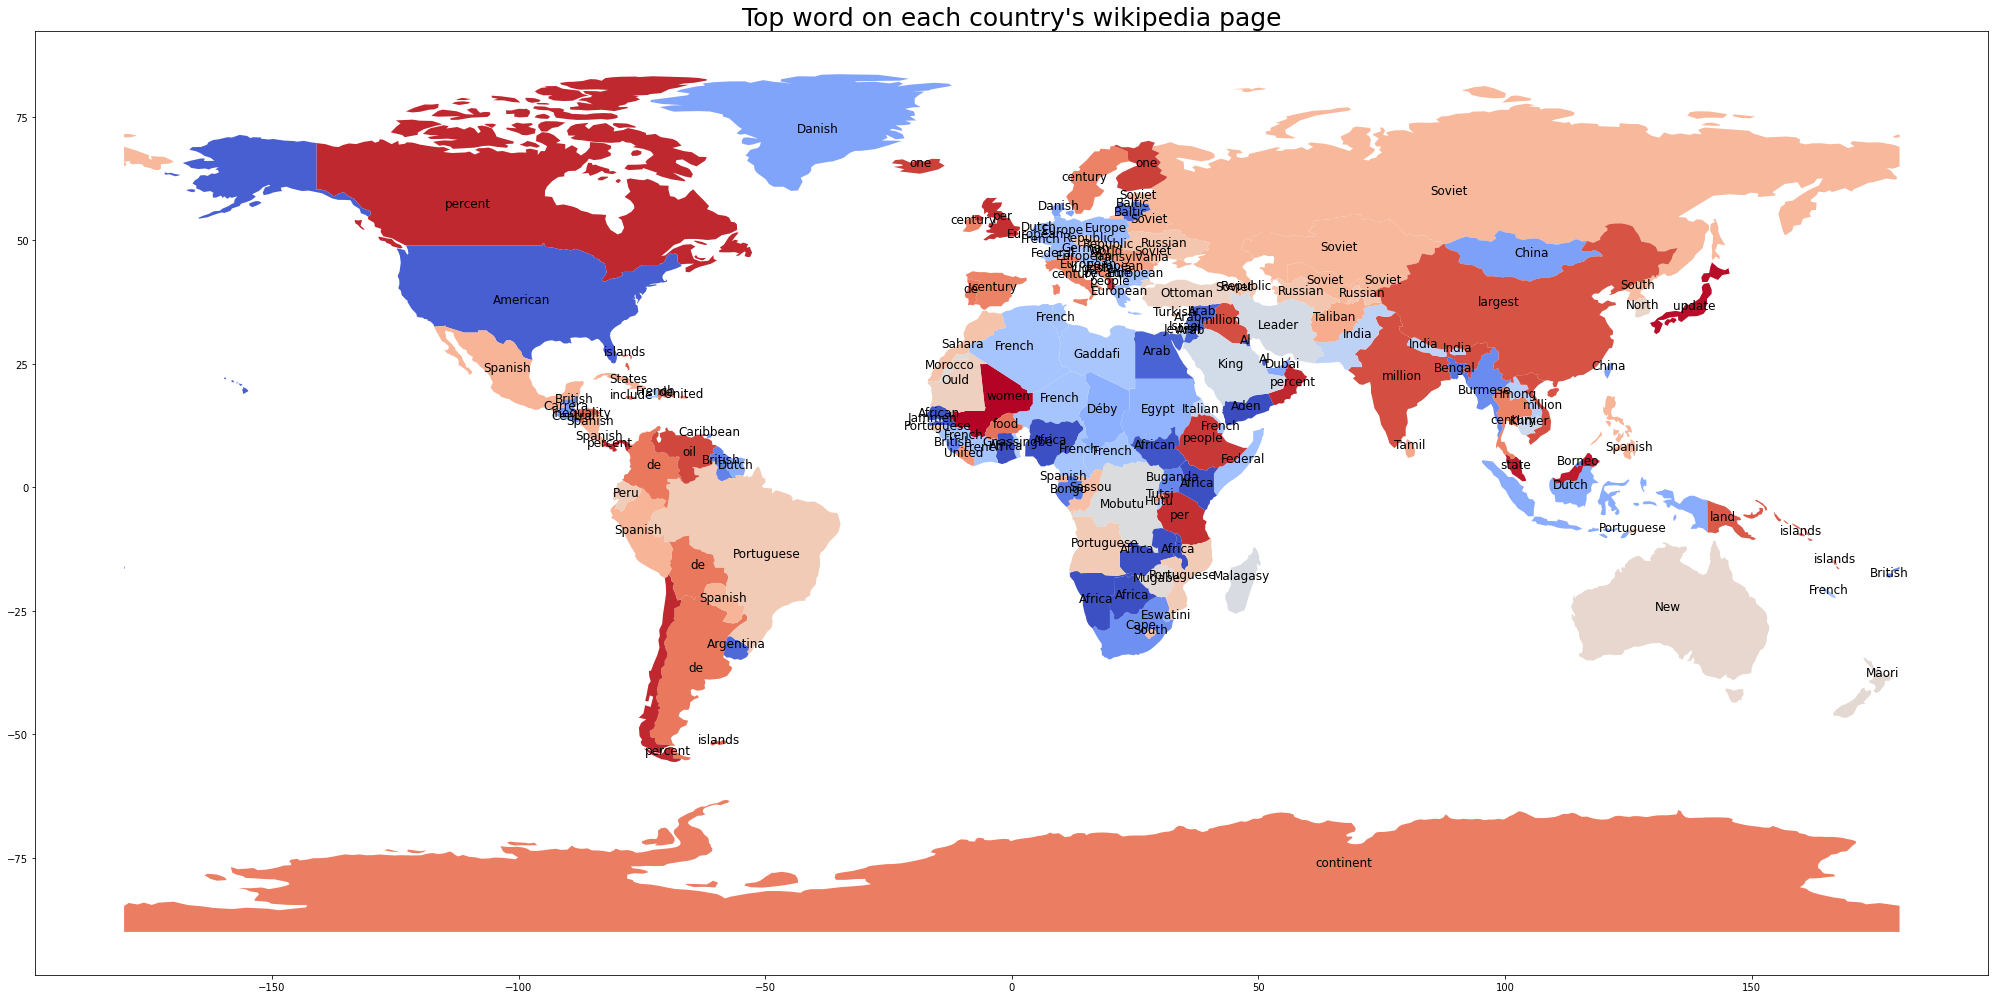

In [184]:
# plot confirmed cases world map 
plt.figure(dpi=1200)
merge.plot(column='word',
           figsize=(35, 30), cmap='coolwarm')
plt.title("Top word on each country's wikipedia page",fontsize=25)
# add countries names and numbers 
for idx, row in merge.iterrows():
  plt.annotate(s=row['word'], xy=row['coords'], horizontalalignment='center', fontsize=12)
plt.savefig('top_words.png')
plt.show()

In [125]:
# generate country code  based on country name 
import pycountry 

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
country_words['CODE']=alpha3code(country_words['CountryName'])
country_words.head()

,CountryName,TopWord,Code,CODE
0,Afghanistan,Taliban,AFG,AFG
1,Albania,Sea,ALB,ALB
2,Algeria,Berber,DZA,DZA
3,American Samoa,States,ASM,ASM
4,Andorra,Catalan,AND,AND


In [127]:
!pip install geopandas

import geopandas

# access geopandas dataset to get location information for each country
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# then merge with our data 
merge=pd.merge(world,country_words,on='CODE')

# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
merge=merge.merge(location,on='name').reset_index()

merge

,index,pop_est,continent,name,CODE,gdp_md_est,geometry,CountryName,TopWord,Code,latitude,longitude
0,0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,Cakobau,FJI,-16.578193,179.414413
1,1,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",Western Sahara,Morocco,ESH,24.215527,-12.885834
2,2,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,percent,CAN,56.130366,-106.346771
3,3,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States,American,USA,37.090240,-95.712891
4,4,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,Soviet,KAZ,48.019573,66.923684
...,...,...,...,...,...,...,...,...,...,...,...,...
127,127,3856181,Europe,Bosnia and Herz.,BIH,42530.0,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",Bosnia and Herzegovina,Yugoslavia,BIH,43.915886,17.679076
128,128,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",Serbia,Kosovo,SRB,44.016521,21.005859
129,129,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",Montenegro,became,MNE,42.708678,19.374390
130,130,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Trinidad and Tobago,Caribbean,TTO,10.691803,-61.222503


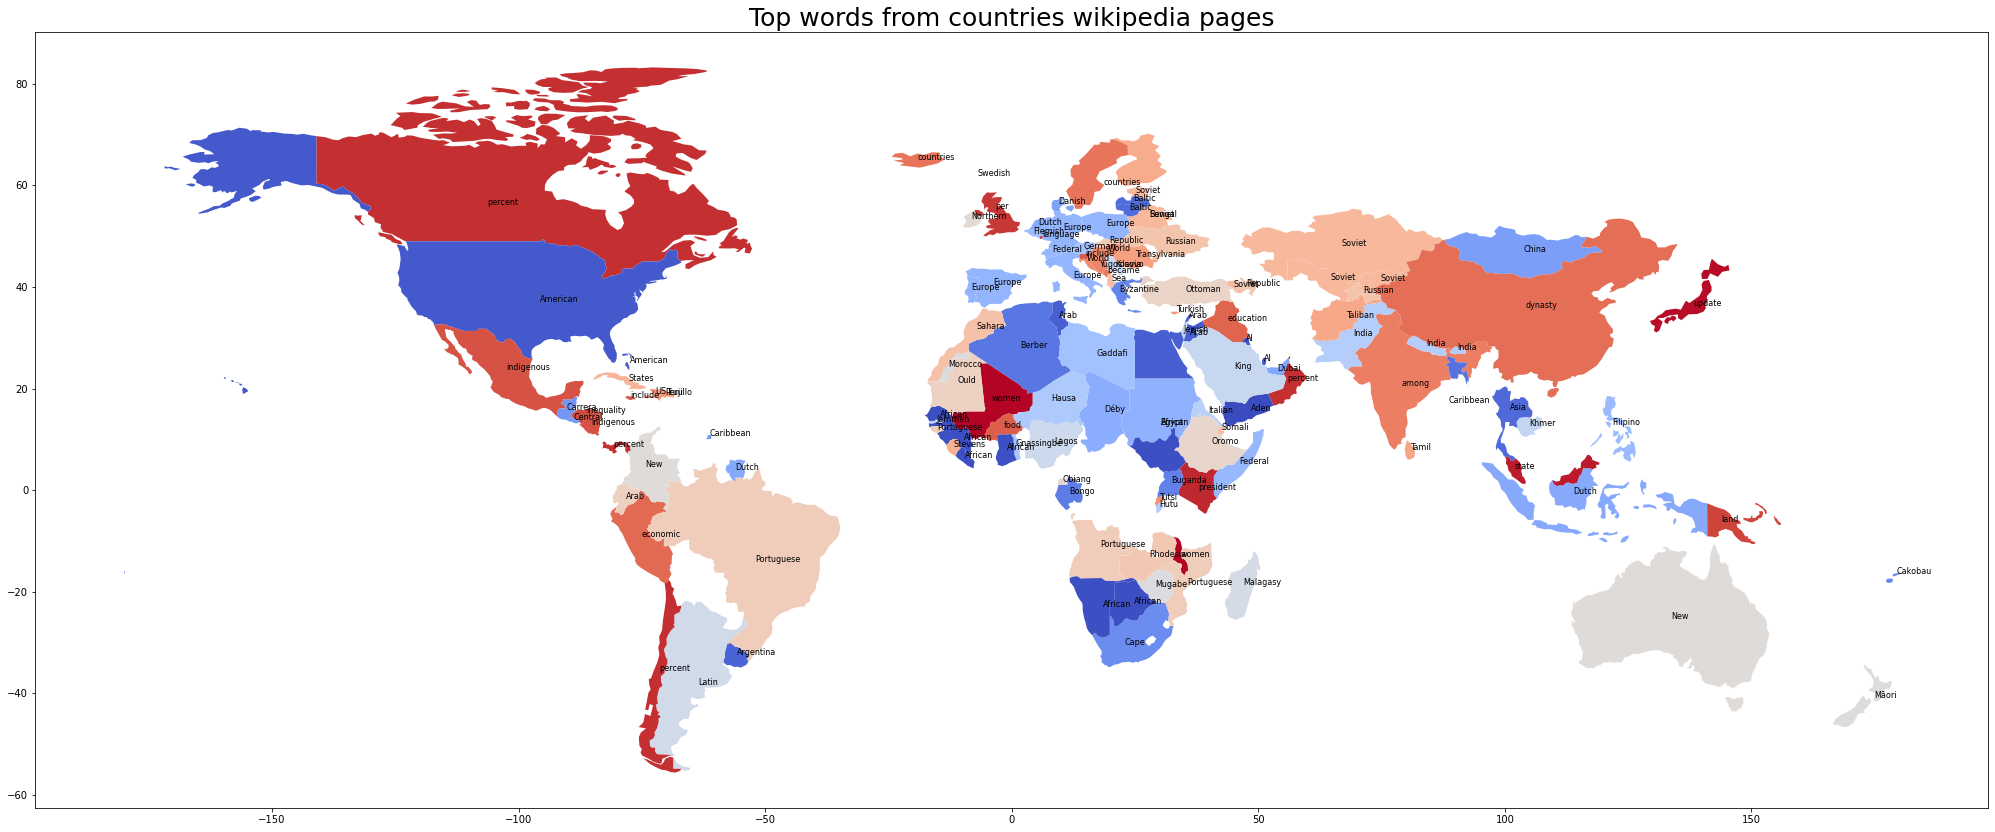

In [144]:
import matplotlib.pyplot as plt


# plot confirmed cases world map 
merge.plot(column='TopWord',
           figsize=(35, 30),
           cmap='coolwarm')
plt.title('Top words from countries wikipedia pages',fontsize=25)
# add countries names and numbers 
for i in range(0,132):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}".format(merge.TopWord[i]),size=8)
plt.savefig('top_words.png')
plt.show()

<Figure size 432x288 with 0 Axes>